In [3]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

In [8]:

import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import pyxpcm
from pyxpcm.models import pcm


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    # ds = both_nc # .copy(deep=True)
    ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, maxvar=maxvar, 
            timeit=True, timeit_verb=1)
    m.fit(ds, features=features, dim='Z') #, inplace=True)
    m.predict(ds, features=features, dim='Z', inplace=True)
    m.predict_proba(ds, features=features, dim='Z', inplace=True)
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    return ds, m


def plot_pcm_labels(xr_ds):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure(figsize=[5, 5])

    ax1 = plt.subplot(1, 1, 1, projection=map_proj)
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, 
                        wspace=0.02)
    ax1.set_extent([-180, 180, -90, -30], carree)
    
    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax1.set_boundary(circle, transform=ax1.transAxes)
    
    plot_boundary()
    

    xr_ds.PCM_LABELS.plot(transform=carree,                      # the data's projection
                          ax=ax1,
                          subplot_kws={"projection": map_proj},  # the plot's projection
                          cbar_kwargs={"shrink": 0.3},
                          )
    
    ax1.coastlines()
    
    ax1.gridlines(xlocs=range(-int(xr_ds.XC.values.min()), int(xr_ds.XC.values.max()), 45), ylocs=range(-80, -19, 20))
    
    plt.show()
    

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
ds, m = pcm_fit_and_post(K=5)
ds

  fit.1-preprocess.1-mask: 12 ms
  fit.1-preprocess.2-feature_THETA.1-ravel: 14 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 153 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 75 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 33 ms
  fit.1-preprocess.2-feature_THETA.5-reduce_fit: 66 ms
  fit.1-preprocess.2-feature_THETA.6-reduce_transform: 7 ms
  fit.1-preprocess.2-feature_THETA.total: 351 ms
  fit.1-preprocess: 351 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 19 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 18 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 49 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 29 ms
  fit.1-preprocess.2-feature_SALT.5-reduce_fit: 52 ms
  fit.1-preprocess.2-feature_SALT.6-reduce_transform: 6 ms
  fit.1-preprocess.2-feature_SALT.total: 178 ms
  fit.1-preprocess: 178 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 547 ms
  fit.fit: 293 ms
  fi

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 5)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 4.0 4.0 4.0 4.0 4.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

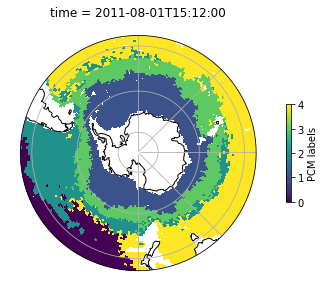

In [9]:
plot_pcm_labels(ds)

In [10]:
ds.to_netcdf('trial_small.nc', engine='netcdf4')

In [11]:
ds1, m1 = pcm_fit_and_post(K=5, maxvar=3)
ds1

  fit.1-preprocess.1-mask: 14 ms
  fit.1-preprocess.2-feature_THETA.1-ravel: 16 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 21 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 69 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 28 ms
  fit.1-preprocess.2-feature_THETA.5-reduce_fit: 48 ms
  fit.1-preprocess.2-feature_THETA.6-reduce_transform: 8 ms
  fit.1-preprocess.2-feature_THETA.total: 194 ms
  fit.1-preprocess: 194 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 18 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 116 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 67 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 29 ms
  fit.1-preprocess.2-feature_SALT.5-reduce_fit: 70 ms
  fit.1-preprocess.2-feature_SALT.6-reduce_transform: 7 ms
  fit.1-preprocess.2-feature_SALT.total: 310 ms
  fit.1-preprocess: 310 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-xarray: 1 ms
  fit.1-preprocess: 525 ms
  fit.fit: 205 ms
  fi

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 5)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan ... 2.274e-45 9.802e-42
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0

In [12]:
m1

<pcm 'gmm' (K: 5, F: 2)>
Number of class: 5
Number of feature: 2
Feature names: odict_keys(['THETA', 'SALT'])
Fitted: True
Feature: 'THETA'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'SALT'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 1.977607

In [13]:
m._reducer

OrderedDict([('THETA',
              PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
                  svd_solver='full', tol=0.0, whiten=False)),
             ('SALT',
              PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
                  svd_solver='full', tol=0.0, whiten=False))])

In [14]:
m._context

<bound method pcm.__timeit_context of <pcm 'gmm' (K: 5, F: 2)>
Number of class: 5
Number of feature: 2
Feature names: odict_keys(['THETA', 'SALT'])
Fitted: True
Feature: 'THETA'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Feature: 'SALT'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 0.199282>

In [15]:
m._reducer

OrderedDict([('THETA',
              PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
                  svd_solver='full', tol=0.0, whiten=False)),
             ('SALT',
              PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
                  svd_solver='full', tol=0.0, whiten=False))])

In [16]:
ds2, m2 = pcm_fit_and_post(K=5, maxvar=30)
ds2

  fit.1-preprocess.1-mask: 14 ms
  fit.1-preprocess.2-feature_THETA.1-ravel: 16 ms
  fit.1-preprocess.2-feature_THETA.2-interp: 19 ms
  fit.1-preprocess.2-feature_THETA.3-scale_fit: 72 ms
  fit.1-preprocess.2-feature_THETA.4-scale_transform: 30 ms
  fit.1-preprocess.2-feature_THETA.5-reduce_fit: 46 ms
  fit.1-preprocess.2-feature_THETA.6-reduce_transform: 8 ms
  fit.1-preprocess.2-feature_THETA.total: 194 ms
  fit.1-preprocess: 194 ms
  fit.1-preprocess.3-homogeniser: 5 ms
  fit.1-preprocess.2-feature_SALT.1-ravel: 16 ms
  fit.1-preprocess.2-feature_SALT.2-interp: 21 ms
  fit.1-preprocess.2-feature_SALT.3-scale_fit: 48 ms
  fit.1-preprocess.2-feature_SALT.4-scale_transform: 28 ms
  fit.1-preprocess.2-feature_SALT.5-reduce_fit: 54 ms
  fit.1-preprocess.2-feature_SALT.6-reduce_transform: 8 ms
  fit.1-preprocess.2-feature_SALT.total: 178 ms
  fit.1-preprocess: 178 ms
  fit.1-preprocess.3-homogeniser: 2 ms
  fit.1-preprocess.4-xarray: 2 ms
  fit.1-preprocess: 401 ms
  fit.fit: 4866 ms
  fi

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 5)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 3.0 3.0 3.0 3.0 3.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan ... 9.572e-242 1.866e-84
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 2.0 2.0 2.0 2.0

In [17]:
pcm = xr.open_dataset('pcm.nc')

In [6]:
%time


CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 22.2 µs
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
(800124, 30)
(800124, 5)


<xarray.Dataset>
Dimensions:     (XC: 2160, YC: 588, Z: 52, pcm_class: 5)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * XC          (XC) float64 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * YC          (YC) float64 -77.98 -77.95 -77.91 ... -30.02 -29.87 -29.72
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 2.0 2.0 2.0 2.0 2.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan ... 1.804e-317 1.574e-317
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 3.0 3.0 3.0 3.0

In [18]:
m.K


5

In [19]:
m.F

2

In [20]:
ds

<xarray.Dataset>
Dimensions:     (XC: 240, YC: 60, Z: 52, pcm_class: 5)
Coordinates:
    time        datetime64[ns] 2011-08-01T15:12:00
  * Z           (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5000.0 -5400.0 -5800.0
  * YC          (YC) float64 -77.98 -77.16 -76.35 ... -31.35 -30.53 -29.72
  * XC          (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Dimensions without coordinates: pcm_class
Data variables:
    SALT        (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    THETA       (Z, YC, XC) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    PCM_LABELS  (YC, XC) float64 nan nan nan nan nan nan ... 4.0 4.0 4.0 4.0 4.0
    PCM_POST    (pcm_class, YC, XC) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0
    PCM_RANK    (pcm_class, YC, XC) float64 nan nan nan nan ... 1.0 1.0 1.0 1.0

In [9]:
del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
ds.to_netcdf('rank.nc', engine='netcdf4')


In [21]:
np.where(ds.PCM_RANK.values==0)

(array([0, 0, 0, ..., 4, 4, 4]),
 array([30, 32, 32, ..., 40, 40, 43]),
 array([152, 135, 145, ...,  39, 235, 201]))

In [22]:
np_array = ds.PCM_RANK.values

In [23]:
np.shape(np_array)

(5, 60, 240)

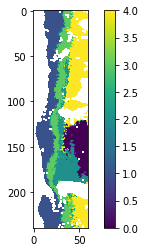

In [24]:
plt.imshow(np_array[0, : , :].T)
plt.colorbar()

In [25]:
where_array = np.where(np_array==0)

TypeError: tuple indices must be integers or slices, not tuple

In [37]:
max_class = np_array == 0
runner_up_class = np_array == 1

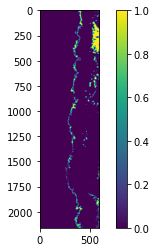

In [16]:
plt.imshow(max_class[2, : , :].T)
plt.colorbar()

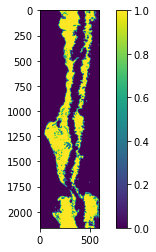

In [15]:
plt.imshow(runner_up_class[2, : , :].T)
plt.colorbar()

In [41]:
runner_up_class[0,1,:200]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [42]:
POST = ds.PCM_POST.values

In [50]:
runner_up_term = runner_up_class * POST
max_term = max_class * POST


In [48]:
runner_up_term[0,1,1000:1200]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

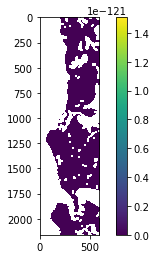

In [58]:
plt.imshow(runner_up_term[1, : , :].T)
plt.colorbar()

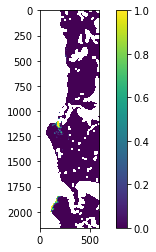

In [57]:
plt.imshow(max_term[1, : , :].T)
plt.colorbar()

In [61]:
i_metric = 1 - np.sum(max_term - runner_up_term, axis=0)

In [62]:
np.shape(i_metric)

(588, 2160)

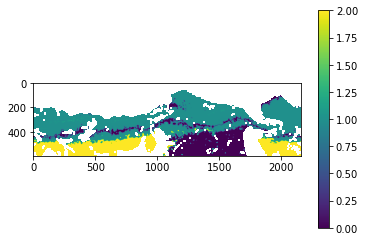

In [63]:
plt.imshow(i_metric)
plt.colorbar()

In [27]:
ranks = ds.PCM_RANK.values
max_class = ranks == 0
runner_up_class = ranks == 1
POST = ds.PCM_POST.values
runner_up_term = np.multiply(runner_up_class, POST)
max_term = np.multiply(max_class, POST)
i_metric = 1 + np.negative(np.sum(max_term, axis=0)) + np.sum(runner_up_term, axis=0)

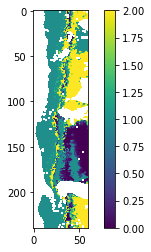

In [28]:
plt.imshow(i_metric.T)
plt.colorbar()

In [112]:
ONE = np.sum(ds.PCM_POST.values, axis=0)


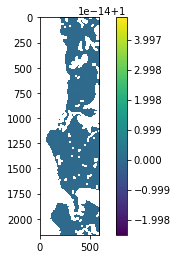

In [113]:
plt.imshow(ONE.T)
plt.colorbar()

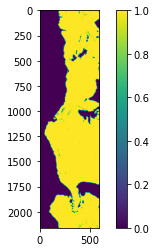

In [79]:
plt.imshow(np.isclose(ONE, 1).T)
plt.colorbar()

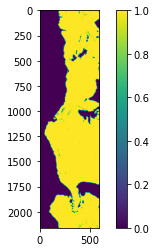

In [85]:
plt.imshow(np.sum(runner_up_class, axis=0).T)
plt.colorbar()

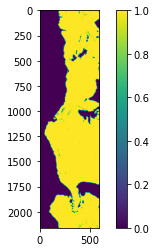

In [86]:
plt.imshow(np.sum(max_class, axis=0).T)
plt.colorbar()

TypeError: Invalid shape (2160,) for image data

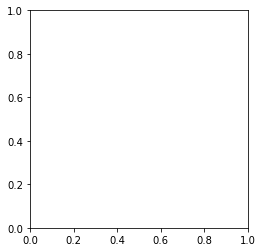

In [87]:
plt.imshow(np.sum(i_metric, axis=0).T)
plt.colorbar()

In [98]:
nranks[0, 1, 5000]

IndexError: index 5000 is out of bounds for axis 2 with size 2160

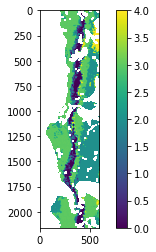

In [105]:
plt.imshow(ranks[2, :, :].T)
plt.colorbar()